TODO: remove this cell before creating PR

*Created* by Margaret Maynard-Reid

---



***Table of Contents***

>[Transfer Learning Using Pretrained ConvNets](#scrollTo=2X4KyhORdSeO)

>>[Prepare Data](#scrollTo=v77rlkCKW0IJ)

>>>[Download data file: cats_and_dogs_filtered.zip](#scrollTo=aXzwKdouXf1h)

>>>[Unzip cats_and_dogs_filtered.zip to /tmp directory](#scrollTo=cmoOdlVWXWRE)

>>>[Prepare training and validation cats and dogs datasets](#scrollTo=9_6h-c5EXN91)

>>>[Create Image Data Generator with Image Augumentation](#scrollTo=wvidPx6jeFzf)

>>[Feature extraction](#scrollTo=rlx56nQtfe8Y)

>>>[Compile our model](#scrollTo=g0ylJXE_kRLi)

>>>[Train the model](#scrollTo=RxvgOYTDSWTx)

>>[Fine tuning](#scrollTo=CqwV-CRdS6Nv)



# Transfer Learning Using Pretrained ConvNets

In this tutorial we will discuss how to classify cats vs dogs images by using transfer learning from a pre-trained network. This will allows us to get higher accuracies than we saw by training our network from scratch.

A **pre-trained model **is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. The intuition behind **transfer learning **is that if this model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. We can leverage these learned feature maps without having to train a large model on a large dataset by using these models as the basis of our own model specific to our task. There are two ways of using a pretrained model:

1. **Feature Extraction** - Feature extraction consists of using the representations of learned by a previous network to extract meaningful features from new samples. We simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that we can repurpose the feature maps learned previously for our dataset. 
  * **Do we use the entire pretrained model or just the convolutional base?** - We use the feature extraction portion of these pretrained convnets (convolutional base) since they are likely to be generic features and learned concepts over a picture. However, the classification part of the pretrained model is often specific to original classification task, and subsequently specific to the set of classes on which the model was trained. 
2. **Fine-Tuning** - Fine tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added classifier layers as well as the last layers of the frozen model. This allows us to "fine tune" the higher order feature representations in addition to our final classifier in order to make them more relevant for the specific task involved. 

### We will follow the general machine learning workflow:
1. Examine and understand data
2. Build an input pipeline - using Keras' ImageDataGenerator as we did in the image classification tutuorial
3. Compose our model 
  * Load in our pretrained model (and pretrained weights)
  * Stack our classification layers on top
4. Train our model
5. Evaluate model

We will see an example of using the pre-trained convnet as the feature extraction and then fine-tune to train the last few layers of the base model.

**Audience:** This post is geared towards beginners with some Keras API and ML background. To get the most out of this post, you should have some basic ML background, know what CNNs are, and be familiar with the Keras `Sequential` API.  

**Time Estimated**: 30 minutes

In [66]:
import tensorflow as tf
from tensorflow import keras
print("TensorFlow verion is ", tf.__version__)

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow verion is  1.10.1


## Data Preprocessing

### Download data - cats_and_dogs_filtered.zip
We will download a filtered version of Kaggle's [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset. Then store the downloaded zip file to the "/tmp/" directory.

In [67]:
# Download data
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip


Redirecting output to ‘wget-log.2’.


### Unzip cats_and_dogs_filtered.zip to /tmp directory
We then extract its contents of the zip file.

In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

### Prepare training and validation cats and dogs datasets

In [69]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


### Create Image Data Generator with Image Augumentation

In [70]:
# Rescale all images by 1./255
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255)
                    #rotation_range=45, 
                    #width_shift_range=.20, 
                    #height_shift_range=.20, 
                    #shear_range=0.2,
                    #horizontal_flip=True, 
                    #zoom_range=0.2)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Feature extraction

In [0]:
IMG_SHAPE = (150, 150, 3)
input_img = keras.layers.Input(shape=IMG_SHAPE)
# Create the base model from the pre-trained model InceptionV3
base_model = tf.keras.applications.InceptionV3(input_tensor=input_img, include_top=False, weights='imagenet')
# base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
# base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

## Freeze the convolutional base
It's important to freeze the convolutional based before we compile and train the model. By freezing (setting layer.trainable = False), we prevent the weights in these layers from being updated during training.

In [0]:
# Freeze all layers in the base model
for layer in base_model.layers: layer.trainable = False

In [73]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
__________________________________________________________________________________________________
conv2d_189

In [0]:
# Define model inputs and outputs
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
final_output = keras.layers.Dense(1, activation='sigmoid')(x)

In [0]:
model = keras.Model(inputs=input_img, outputs=final_output) 

### Compile our model
Let's compile our model before we train it.

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )

### Train the model

In [77]:
batch_size = 64
epochs = 10
history = model.fit_generator(train_generator, 
                              train_generator.n // batch_size, 
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_generator.n // batch_size)

Epoch 1/10
31/31 [==============================] - 14s 444ms/step - loss: 0.6850 - acc: 0.5984 - val_loss: 0.2125 - val_acc: 0.9167
Epoch 2/10
31/31 [==============================] - 4s 130ms/step - loss: 0.5403 - acc: 0.7065 - val_loss: 0.3426 - val_acc: 0.8867
Epoch 3/10
31/31 [==============================] - 4s 129ms/step - loss: 0.5050 - acc: 0.7355 - val_loss: 0.1816 - val_acc: 0.9233
Epoch 4/10
31/31 [==============================] - 4s 142ms/step - loss: 0.4923 - acc: 0.7613 - val_loss: 0.1612 - val_acc: 0.9367
Epoch 5/10
31/31 [==============================] - 4s 129ms/step - loss: 0.4627 - acc: 0.7790 - val_loss: 0.1630 - val_acc: 0.9400
Epoch 6/10
31/31 [==============================] - 4s 128ms/step - loss: 0.4343 - acc: 0.7968 - val_loss: 0.3410 - val_acc: 0.9200
Epoch 7/10
31/31 [==============================] - 4s 142ms/step - loss: 0.3856 - acc: 0.8145 - val_loss: 0.3048 - val_acc: 0.9367
Epoch 8/10
31/31 [==============================] - 4s 127ms/step - loss: 0

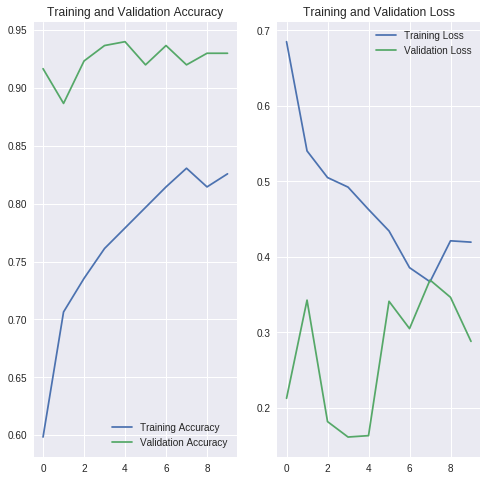

In [78]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Fine tuning

In [79]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [0]:
#split_at = 200
# Freeze all the layers before split_at
#for layer in model.layers[:split_at]: layer.trainable = False
  
# Unfreeze all the layers after aplit_at
#for layer in model.layers[split_at:]: layer.trainable = True

In [81]:
unfreeze = False
for layer in base_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# as optimizer, we will use SGD with a very low learning rate
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-05, momentum=0.9),
   #           optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit_generator(train_generator, 
                              train_generator.n // batch_size, 
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_generator.n // batch_size)

Epoch 1/10
31/31 [==============================] - 21s 682ms/step - loss: 0.3623 - acc: 0.8516 - val_loss: 0.2752 - val_acc: 0.9300
Epoch 2/10
31/31 [==============================] - 6s 179ms/step - loss: 0.3791 - acc: 0.8323 - val_loss: 0.2582 - val_acc: 0.9267
Epoch 3/10
31/31 [==============================] - 6s 179ms/step - loss: 0.3392 - acc: 0.8435 - val_loss: 0.2549 - val_acc: 0.9300
Epoch 4/10
31/31 [==============================] - 6s 191ms/step - loss: 0.3545 - acc: 0.8452 - val_loss: 0.2423 - val_acc: 0.9333
Epoch 5/10
31/31 [==============================] - 6s 180ms/step - loss: 0.3853 - acc: 0.8242 - val_loss: 0.2545 - val_acc: 0.9267
Epoch 6/10
31/31 [==============================] - 6s 182ms/step - loss: 0.4048 - acc: 0.8242 - val_loss: 0.2546 - val_acc: 0.9267
Epoch 7/10
31/31 [==============================] - 6s 192ms/step - loss: 0.3382 - acc: 0.8532 - val_loss: 0.2619 - val_acc: 0.9200
Epoch 8/10
31/31 [==============================] - 6s 183ms/step - loss: 0

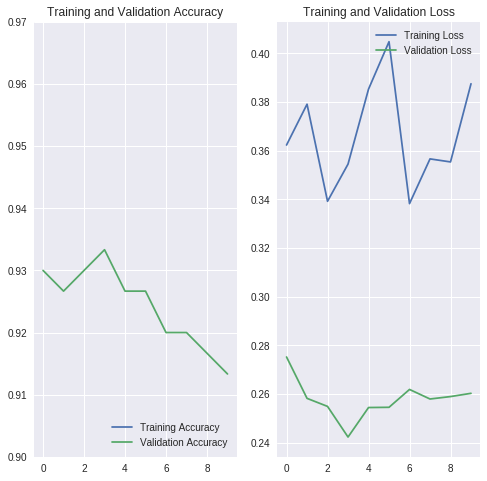

In [82]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim((0.9, 0.97))
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()